In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
from scipy.optimize import minimize
from scipy.signal import convolve2d

import pathlib
import sys

home = pathlib.Path().resolve().parent
path = str(pathlib.Path(home, r'Andrey'))
sys.path.insert(0, home)

from src.mixture_fit import gen_data, fits, sum_exp_curv, fit, sum_exp, loss_function, right_order
from src.data_loading import load_data
from src.optimal_number import optimal_params
from src.log_data_analysis import log_estimate, bounds
from src.errors import bootstrap_resudial, bootstrap_residual
from src.bootstrapping import bootstrap, final_guess
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

%matplotlib widget

## Чувствительность/разрешающая способность.

Способность различать две (или более) компоненты смеси при их наличии.

Тестируется на наборах R2-R4 (worst case), R1-R2-x-*-*-new.txt, R2-R5-*-*-new.txt + симуляции с разным подбором коэффициентов самодиффузии и содержания компонент.

In [2]:
def c_picker(val, lim1=0.1, lim2=0.3):
    if val < lim1:
        return 'green'
    elif val < lim2:
        return 'orange'
    else:
        return 'red'

def draw(array, D_axis, w_axis, title, res, true_res):
    abs_diff = (np.abs(res - true_res)/res).mean(1)
    colors = [c_picker(abs_diff_el, 0.1, 0.3) for abs_diff_el in abs_diff]
    plt.pcolormesh(D_axis, w_axis, array, vmin=0, vmax=1)
    plt.scatter(res[:,1]/res[:,3], np.abs(res[:,2] - res[:,0]), edgecolors='black', c=colors)
    plt.title(title)
    plt.xlabel('D1/D2 ratio')
    plt.ylabel('w2-w1')
    plt.colorbar(orientation='horizontal')
    plt.xticks(rotation=45)
    plt.xlim(left=D_axis.min())
    plt.ylim(bottom=w_axis.min())

def lim_func(x, *params):
    a, b, c = params
    return a / (x - b) ** 2 + c
    # return c/(np.exp(a * (x - b)) + 1)

def lim_func_optim(params, x, y):
    return ((lim_func(x, *params) - y) ** 2).sum()

def adjecent(x):
    grid = np.array([
        [1, 1, 1],
        [1, 0, 1],
        [1, 1, 1]
    ])
    return np.logical_and(convolve2d(x, grid, mode='same') > 1, np.logical_not(x))


def calc_fit(data, x_grid, y_grid, limiter=0.1):
    # np.where()
    y_idx, x_idx = np.where(adjecent(np.abs(np.nan_to_num(data, nan=1))<limiter))
    x = x_grid[x_idx]
    y = y_grid[y_idx]
    params = minimize(lim_func_optim, [1, 0.8, 1], args =(x, y))
    return params.x

In [6]:
def resolution(fun: callable, bs_num=100, size=20, log=True, save_path=None, *args, **kwargs):
    # Calculate the parameter space of given size.
    w_space = np.linspace(0, 0.5, size)
    D_space = np.linspace(0.1, 1, size)

    folder = pathlib.Path(path,'data', 'R2_5times')
    data_path = pathlib.Path(folder, f'DOSY-R2-1-4-DMSO-128points-1.txt')
    x, _ = load_data(data_path)
    guess_arr = np.zeros((len(w_space), len(D_space)))
    mean_arr = np.zeros((len(w_space), len(D_space), 4))
    std_arr = np.zeros((len(w_space), len(D_space), 4))
    with tqdm(total=len(w_space) * len(D_space), desc='Calculating parameter space') as pbar:
        for w_idx, w1 in enumerate(w_space):
            for D_idx, D1 in enumerate(D_space):
                w2, D2 = 1 - w1, 1
                params = np.array([w1, D1, w2, D2])
                y_model = sum_exp(params, x)
                res, optim_res = bootstrap(fun, x, y_model, 0.0086, num=bs_num, show_progress=False, *args, **kwargs)

                correct_guess = (optim_res[:, 0] == 1)
                if correct_guess.sum() == 0:
                    correct_mean = np.zeros(4)
                    correct_std = np.zeros(4)
                else:
                    stacked_res = np.vstack(optim_res[:, 1][correct_guess])
                    correct_mean = stacked_res.mean(0)
                    correct_std = stacked_res.std(0)

                guess_arr[w_idx, D_idx] = correct_guess.sum()
                mean_arr[w_idx, D_idx] = correct_mean
                std_arr[w_idx, D_idx] = correct_std

                pbar.update(1)
    
    # Calculate the parameteres of real data with chosen optimization method.
    files = glob('data/R?-R?/R?-R?-?-?*.txt')
    D_coef_dict = {'R1':0.30, 'R2':1.04, 'R4':0.69, 'R5':0.46}

    label, results = [], []
    for file in tqdm(files, desc='Calculating real data optimization parameteres'):
        x, y = load_data(file)
        try:
            res = fun(x, y, *args, **kwargs)
            y_model = sum_exp(res[-1], x)
            label.append(file[11:file.find('.txt')])
            results.append(res[1])
        except ValueError:
            label.append(file[11:file.find('.txt')])
            results.append(np.zeros(4))
            
    results = np.vstack(results)

    # Calculate the expected values of real data
    true_result = []
    for file in files:
        parser = file[11:20].split('-')
        total_portions = int(parser[2]) + int(parser[3])
        out_params = [int(parser[2])/total_portions, D_coef_dict[parser[0]], int(parser[3])/total_portions, D_coef_dict[parser[1]]]
        out_params = right_order(np.array(out_params))
        true_result.append(out_params)
    true_result = np.vstack(true_result)

    if log:
        D_axis = D_space-np.diff(D_space)[0]/2
        w_axis = 1 - 2 * (w_space)
        w_axis = w_axis - np.diff(w_axis)[0]/2

        x_draw = np.linspace(0, 1, 100)

        plt.close('all')
        plt.figure(figsize=(14,6))

        plt.subplot(1,3,1)
        draw(guess_arr/guess_arr.max(), D_axis, w_axis, 'Fraction of correct guesses', results, true_result)
        params1 = calc_fit(guess_arr, D_axis, w_axis, 9)
        plt.plot(x_draw, lim_func(x_draw, *params1), color='red', linewidth=3)

        plt.subplot(1,3,2)
        w_diff = np.abs(mean_arr[:,:,2] - mean_arr[:,:,0])
        w_residual = np.abs(w_diff.T-(1 - 2 * (w_space))).T
        draw(w_residual, D_axis, w_axis, '|w2-w1|', results, true_result)
        # params2 = calc_fit(w_residual, D_axis, w_axis, 0.05)
        # plt.plot(x_draw, lim_func(x_draw, *params2), color='red', linewidth=3)

        plt.subplot(1,3,3)
        D_ratio = mean_arr[:,:,1]/mean_arr[:,:,3]
        D_residual = np.abs(D_ratio-D_space)
        draw(D_residual, D_axis, w_axis, 'D_min/D_max', results, true_result)
        # params3 = calc_fit(D_residual, D_axis, w_axis, 0.05)
        # plt.plot(x_draw, lim_func(x_draw, *params3), color='red', linewidth=3)

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150)
        else:
            plt.show()

        print('Area')
        print(f'from guesses = {(np.clip(lim_func(D_axis, *params1), 0, None) * np.diff(D_axis)[-1]).sum():.3f}')
        # print(f'from   w2-w1 = {(np.clip(lim_func(D_axis, *params2), 0, None) * np.diff(D_axis)[-1]).sum():.3f}')
        # print(f'from   D1/D2 = {(np.clip(lim_func(D_axis, *params3), 0, None) * np.diff(D_axis)[-1]).sum():.3f}')
        print()

        print('Max resolution')

        max_idx = np.argmax(D_axis + np.clip(lim_func(D_axis, *params1), 0, None))
        print(f'from guesses: w2-w1 = {lim_func(D_axis, *params1)[max_idx]:.3f}, D1/D2 = {D_axis[max_idx]:.3f}')

        # max_idx = np.argmax(D_axis + np.clip(lim_func(D_axis, *params2), 0, None))
        # print(f'from   w2-w1: w2-w1 = {lim_func(D_axis, *params2)[max_idx]:.3f}, D1/D2 = {D_axis[max_idx]:.3f}')

        # max_idx = np.argmax(D_axis + np.clip(lim_func(D_axis, *params3), 0, None))
        # print(f'from   D1/D2: w2-w1 = {lim_func(D_axis, *params3)[max_idx]:.3f}, D1/D2 = {D_axis[max_idx]:.3f}')
            
    return w_space, D_space, guess_arr, mean_arr, std_arr

Calculating parameter space:   0%|          | 0/400 [00:00<?, ?it/s]

Calculating real data optimization parameteres:   0%|          | 0/37 [00:00<?, ?it/s]

C:\Users\uwu00\AppData\Local\Temp\ipykernel_19176\3727919407.py:86: RuntimeWarning: invalid value encountered in divide
  D_ratio = mean_arr[:,:,1]/mean_arr[:,:,3]


Area
from guesses = 0.337

Max resolution
from guesses: w2-w1 = 0.824, D1/D2 = 0.218


Calculating parameter space:   0%|          | 0/400 [00:00<?, ?it/s]

Calculating real data optimization parameteres:   0%|          | 0/37 [00:00<?, ?it/s]

C:\Users\uwu00\AppData\Local\Temp\ipykernel_19176\3727919407.py:86: RuntimeWarning: invalid value encountered in divide
  D_ratio = mean_arr[:,:,1]/mean_arr[:,:,3]


Area
from guesses = 0.597

Max resolution
from guesses: w2-w1 = 0.870, D1/D2 = 0.503


Calculating parameter space:   0%|          | 0/400 [00:00<?, ?it/s]

Calculating real data optimization parameteres:   0%|          | 0/37 [00:00<?, ?it/s]

C:\Users\uwu00\AppData\Local\Temp\ipykernel_19176\3727919407.py:86: RuntimeWarning: invalid value encountered in divide
  D_ratio = mean_arr[:,:,1]/mean_arr[:,:,3]


Area
from guesses = 0.606

Max resolution
from guesses: w2-w1 = 0.862, D1/D2 = 0.455


Calculating parameter space:   0%|          | 0/400 [00:00<?, ?it/s]

Calculating real data optimization parameteres:   0%|          | 0/37 [00:00<?, ?it/s]

C:\Users\uwu00\AppData\Local\Temp\ipykernel_19176\3727919407.py:86: RuntimeWarning: invalid value encountered in divide
  D_ratio = mean_arr[:,:,1]/mean_arr[:,:,3]


Area
from guesses = 0.632

Max resolution
from guesses: w2-w1 = 0.796, D1/D2 = 0.597


Calculating parameter space:   0%|          | 0/400 [00:00<?, ?it/s]

Calculating real data optimization parameteres:   0%|          | 0/37 [00:00<?, ?it/s]

C:\Users\uwu00\AppData\Local\Temp\ipykernel_19176\3727919407.py:86: RuntimeWarning: invalid value encountered in divide
  D_ratio = mean_arr[:,:,1]/mean_arr[:,:,3]


Area
from guesses = 0.666

Max resolution
from guesses: w2-w1 = 0.852, D1/D2 = 0.645


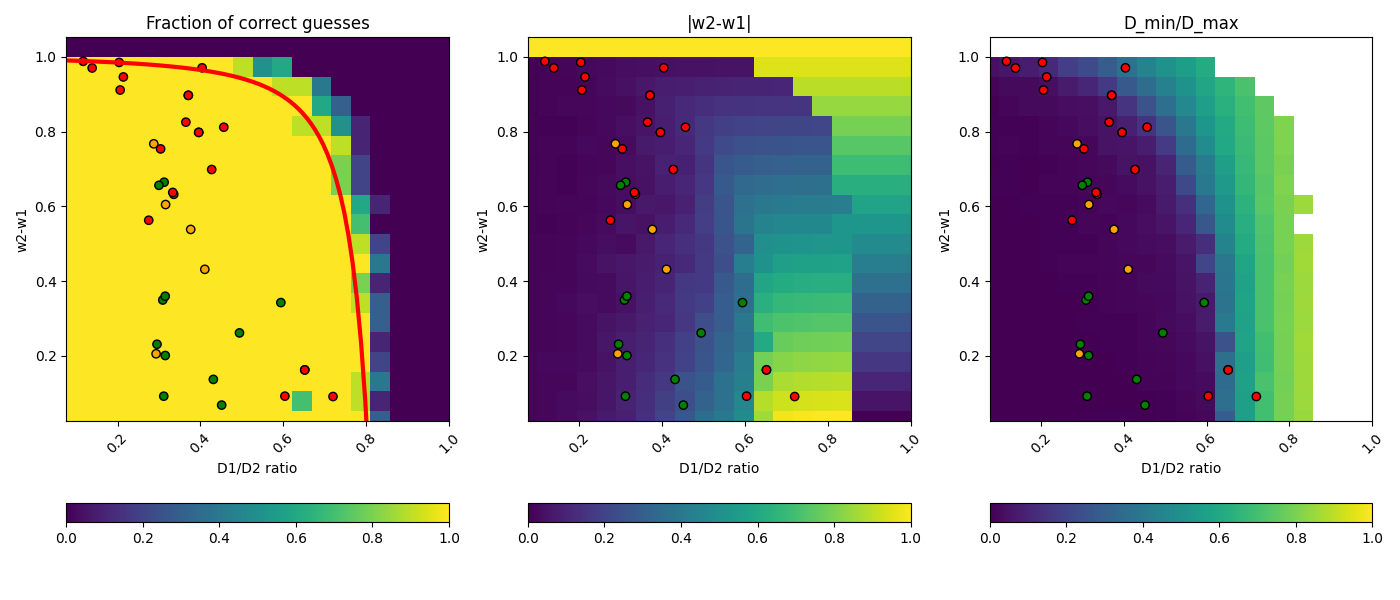

In [7]:
path_to_fig = r'D:\Programms\Jupyter\NPM\Andrey\figures\Comparison'
w_space, D_space, guess_arr, mean_arr, std_arr = resolution(fits, bs_num=10, size=20,
                                                            save_path=path_to_fig + r'\res_weighted=False_reg=0.png',
                                                            method='BFGS', boost=True)

w_space, D_space, guess_arr, mean_arr, std_arr = resolution(fits, bs_num=10, size=20,
                                                            save_path=path_to_fig + r'\res_weighted=True_reg=0.png',
                                                            method='BFGS', boost=True, sigma=0.018)

w_space, D_space, guess_arr, mean_arr, std_arr = resolution(fits, bs_num=10, size=20,
                                                            save_path=path_to_fig + r'\res_weighted=True_reg=0.05.png',
                                                            method='BFGS', boost=True, sigma=0.018, reg=0.05)

w_space, D_space, guess_arr, mean_arr, std_arr = resolution(fits, bs_num=10, size=20,
                                                            save_path=path_to_fig + r'\res_weighted=True_reg=0.25.png',
                                                            method='BFGS', boost=True, sigma=0.018, reg=0.25)

# w_space, D_space, guess_arr, mean_arr, std_arr = resolution(fits, bs_num=10, size=20,
#                                                             save_path=path_to_fig + r'\res_weighted=True_reg=0.5.png',
#                                                             method='BFGS', boost=True, sigma=0.018, reg=0.5)

w_space, D_space, guess_arr, mean_arr, std_arr = resolution(fits, bs_num=10, size=20,
                                                            save_path=path_to_fig + r'\res_weighted=True_reg=1.png',
                                                            method='BFGS', boost=True, sigma=0.018, reg=1)

In [4]:
files = glob('data/R?-R?/R?-R?-?-?*.txt')

label, results = [], []
for file in tqdm(files):
    x, y = load_data(file)
    try:
        res = fits_boost(x, y, method='BFGS')
        y_model = sum_exp(res[-1], x)
        # _, res_opt = bootstrap(fits, x, y_model, 0.0086, num=50, show_progress=False, method='L-BFGS-B')
        # res_std = [np.zeros(2 * n) for n in range(1, 6)]
        # res_opt = final_guess(x, y, 0.02, res, res_std)
        label.append(file[11:file.find('.txt')])
        results.append(res[1])
        # correct_guess = (res_opt[:, 0] == 1).mean() > 0.99
    except ValueError:
        label.append(file[11:file.find('.txt')])
        results.append(np.zeros(4))
        
results = np.vstack(results)

  0%|          | 0/37 [00:00<?, ?it/s]

In [5]:
D_coef_dict = {'R1':0.30, 'R2':1.04, 'R4':0.69, 'R5':0.46}

In [6]:
true_result = []
for file in files:
    parser = file[11:20].split('-')
    total_portions = int(parser[2]) + int(parser[3])
    out_params = [int(parser[2])/total_portions, D_coef_dict[parser[0]], int(parser[3])/total_portions, D_coef_dict[parser[1]]]
    out_params = right_order(np.array(out_params))
    true_result.append(out_params)
true_result = np.vstack(true_result)

C:\Users\uwu00\AppData\Local\Temp\ipykernel_10116\988960057.py:23: RuntimeWarning: invalid value encountered in divide
  D_ratio = mean_arr[:,:,1]/mean_arr[:,:,3]


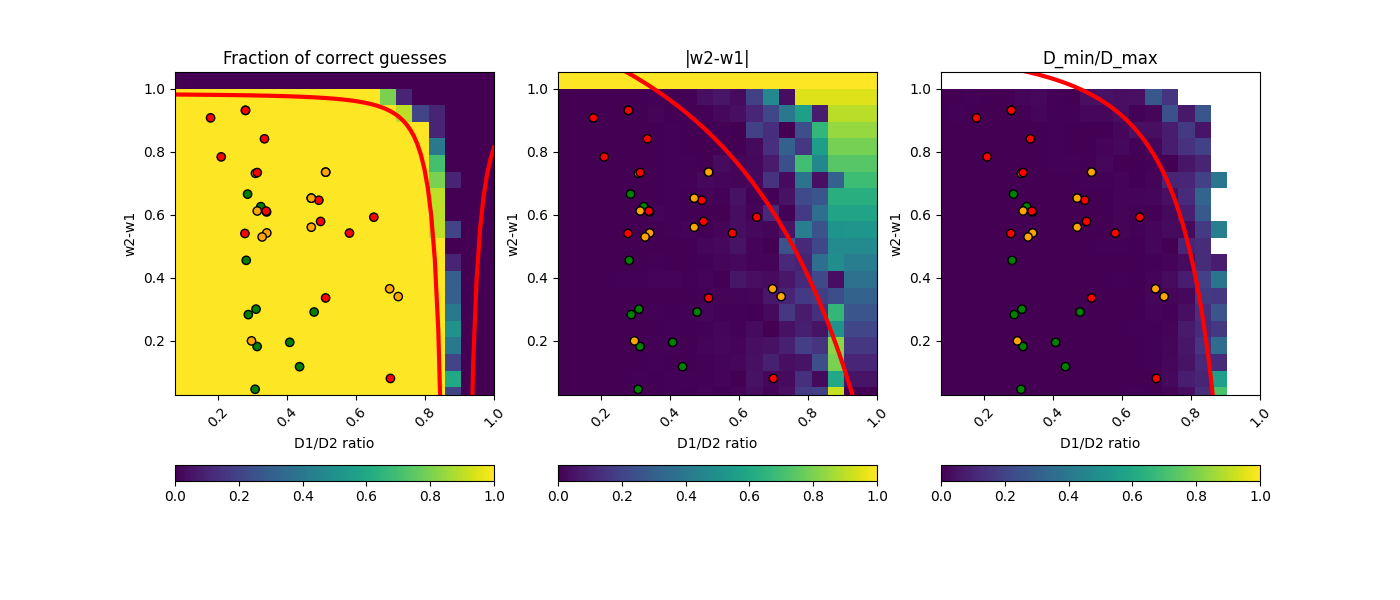

In [10]:
D_axis = D_space-np.diff(D_space)[0]/2
w_axis = 1 - 2 * (w_space)
w_axis = w_axis - np.diff(w_axis)[0]/2

x_draw = np.linspace(0, 1, 100)

plt.close('all')
plt.figure(figsize=(14,6))

plt.subplot(1,3,1)
draw(guess_arr/guess_arr.max(), D_axis, w_axis, 'Fraction of correct guesses', results, true_result)
params1 = calc_fit(guess_arr, D_axis, w_axis, 9)
plt.plot(x_draw, lim_func(x_draw, *params1), color='red', linewidth=3)

plt.subplot(1,3,2)
w_diff = np.abs(mean_arr[:,:,2] - mean_arr[:,:,0])
w_residual = np.abs(w_diff.T-(1 - 2 * (w_space))).T
draw(w_residual, D_axis, w_axis, '|w2-w1|', results, true_result)
params2 = calc_fit(w_residual, D_axis, w_axis, 0.05)
plt.plot(x_draw, lim_func(x_draw, *params2), color='red', linewidth=3)

plt.subplot(1,3,3)
D_ratio = mean_arr[:,:,1]/mean_arr[:,:,3]
D_residual = np.abs(D_ratio-D_space)
draw(D_residual, D_axis, w_axis, 'D_min/D_max', results, true_result)
params3 = calc_fit(D_residual, D_axis, w_axis, 0.05)
plt.plot(x_draw, lim_func(x_draw, *params3), color='red', linewidth=3)

plt.show()

In [11]:
print('Area')
print(f'from guesses = {(np.clip(lim_func(D_axis, *params1), 0, None) * np.diff(D_axis)[-1]).sum():.3f}')
print(f'from   w2-w1 = {(np.clip(lim_func(D_axis, *params2), 0, None) * np.diff(D_axis)[-1]).sum():.3f}')
print(f'from   D1/D2 = {(np.clip(lim_func(D_axis, *params3), 0, None) * np.diff(D_axis)[-1]).sum():.3f}')
print()

print('Max resolution')

max_idx = np.argmax(D_axis + np.clip(lim_func(D_axis, *params1), 0, None))
print(f'from guesses: w2-w1 = {lim_func(D_axis, *params1)[max_idx]:.3f}, D1/D2 = {D_axis[max_idx]:.3f}')

max_idx = np.argmax(D_axis + np.clip(lim_func(D_axis, *params2), 0, None))
print(f'from   w2-w1: w2-w1 = {lim_func(D_axis, *params2)[max_idx]:.3f}, D1/D2 = {D_axis[max_idx]:.3f}')

max_idx = np.argmax(D_axis + np.clip(lim_func(D_axis, *params3), 0, None))
print(f'from   D1/D2: w2-w1 = {lim_func(D_axis, *params3)[max_idx]:.3f}, D1/D2 = {D_axis[max_idx]:.3f}')

Area
from guesses = 0.773
from   w2-w1 = 0.697
from   D1/D2 = 0.737

Max resolution
from guesses: w2-w1 = 0.708, D1/D2 = 0.976
from   w2-w1: w2-w1 = 0.870, D1/D2 = 0.503
from   D1/D2: w2-w1 = 0.917, D1/D2 = 0.597


In [59]:
np.zeros(6)[:-2]

array([0., 0., 0., 0.])